# Feature Extraction

The aim of the project is the detect vehicles using HOG features. In this notebook feature extration methods will be implemented.

For the implementation details and the results please refer to [project report](./project-report.md).

In [14]:
# Import dependencies
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
import os

%matplotlib inline

## HOG Features

In [15]:
# define a function to get hog feature
def get_hog(img, pix_per_cell=(8,8),
    cell_per_block=(2,2), orient=9,
    output_img=False):
    """Get HOG feature as flat array.
    
    Returns features as flattened array and the hog image.
    
    Args:
        pix_per_cell(tuple): 2-tuple, specifies the cell size over which each 
            gradient histogram is computed.
        cells_per_block(tuple): 2-tuple, specifies the local area over which 
            the histogram counts in a given cell will be normalized. 
        orient(int): Represents the number of orientation bins.
        output_img(bool): If `False` hog image will not be returned.
    """
    
    if output_img:
        features, hog_image = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=True, feature_vector=True, block_norm='L2-Hys')
        
        return features, hog_image
    else:
        features = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=False, feature_vector=True, block_norm='L2-Hys')
        
        return features

Explore the outputs for a car from a test image

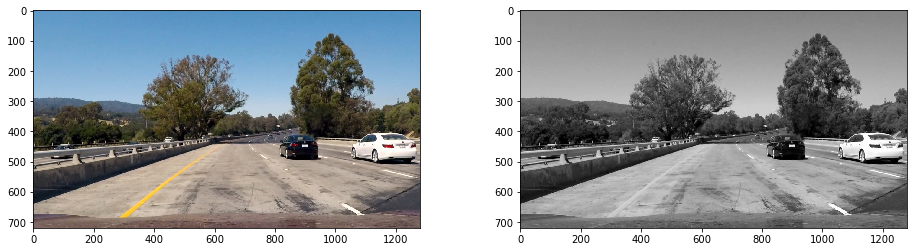

In [16]:
# read test1 image and convert to gray
test1 = mpimg.imread('./test_images/test1.jpg')
gray = cv2.cvtColor(test1, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(test1)
plt.subplot(122)
plt.imshow(gray, cmap='gray')
plt.show()
plt.close()

The feature number of 2x2 cell size: 139356
The feature number of 8x8 cell size: 7524
The feature number of 16x16 cell size: 1620


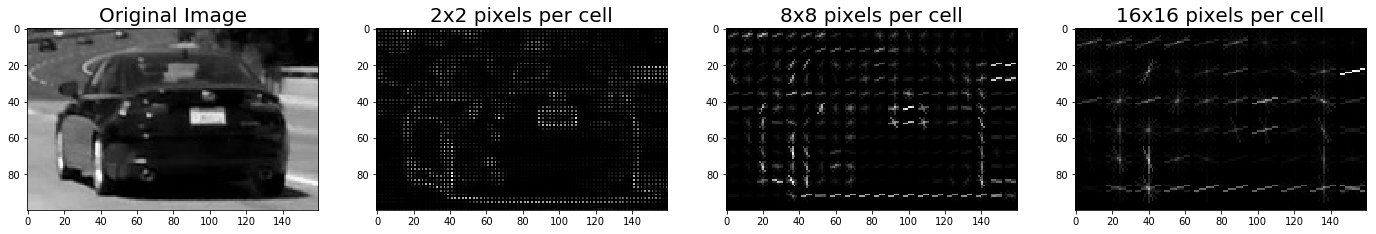

In [17]:
# cropout and investigate the car for various pixel numbers in cells
car = gray[400:500,800:960]

pix_per_cell_list = [
    (2, 2),
    (8, 8),
    (16, 16)
]

plt.figure(figsize=(24,8))
plt.subplot(1,4,1)
plt.imshow(car, cmap='gray')
plt.title('Original Image', fontsize=20)
i = 2
for pix_per_cell in pix_per_cell_list:
    features, hog_img = get_hog(car, pix_per_cell=pix_per_cell, output_img=True)
    print('The feature number of ' + str(pix_per_cell[0]) 
        + 'x' + str(pix_per_cell[1]) + ' cell size: '
        + str(features.shape[0]))
    plt.subplot(1,4,i)
    plt.imshow(hog_img, cmap='gray')
    plt.title(
        str(pix_per_cell[0]) + 'x' 
        + str(pix_per_cell[1]) + ' pixels per cell',
        fontsize=20)
    i += 1
plt.show()
plt.close()

(64, 64)
(6, 6, 3, 3, 9)
(2916,)


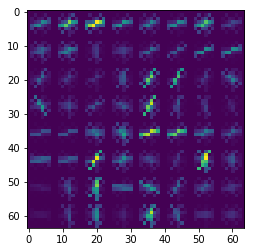

In [24]:
features, hog_image = hog(
            car[0:64,0:64], orientations=9, 
            pixels_per_cell=(8,8), cells_per_block=(3,3),
            visualise=True, feature_vector=False, block_norm='L2-Hys')
features2, hog_image = hog(
            car[0:64,0:64], orientations=9, 
            pixels_per_cell=(8,8), cells_per_block=(3,3),
            visualise=True, feature_vector=True, block_norm='L2-Hys')
print(car[0:64,0:64].shape)
print(features.shape)
print(features2.shape)
plt.imshow(hog_image)
plt.show()
plt.close()

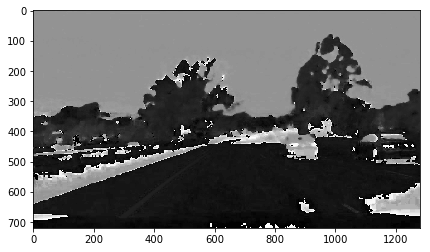

The feature number of 2x2 cell size: 139356
The feature number of 8x8 cell size: 7524
The feature number of 16x16 cell size: 1620


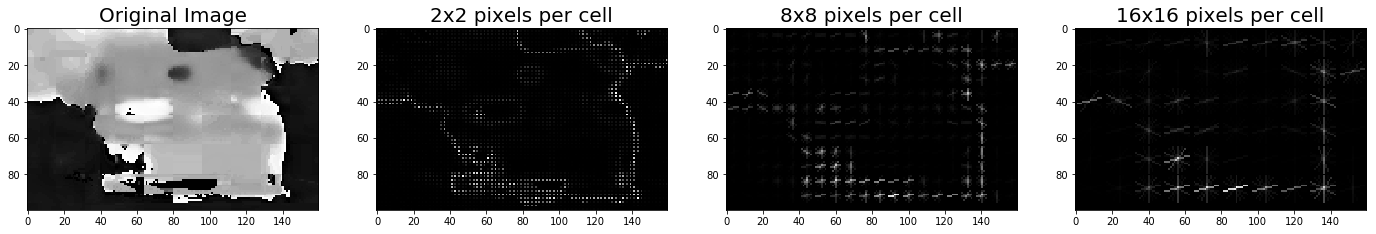

In [27]:
# test on h channel
test1_hsv = cv2.cvtColor(test1, cv2.COLOR_RGB2HSV)
test1_h = test1_hsv[:,:,0]

plt.figure(figsize=(12,4))
plt.imshow(test1_h, cmap='gray')
plt.show()
plt.close()

car = test1_h[400:500,800:960]

pix_per_cell_list = [
    (2, 2),
    (8, 8),
    (16, 16)
]

plt.figure(figsize=(24,8))
plt.subplot(1,4,1)
plt.imshow(car, cmap='gray')
plt.title('Original Image', fontsize=20)
i = 2
for pix_per_cell in pix_per_cell_list:
    features, hog_img = get_hog(car, pix_per_cell=pix_per_cell, output_img=True)
    print('The feature number of ' + str(pix_per_cell[0]) 
        + 'x' + str(pix_per_cell[1]) + ' cell size: '
        + str(features.shape[0]))
    plt.subplot(1,4,i)
    plt.imshow(hog_img, cmap='gray')
    plt.title(
        str(pix_per_cell[0]) + 'x' 
        + str(pix_per_cell[1]) + ' pixels per cell',
        fontsize=20)
    i += 1
plt.show()
plt.close()

## Prepare The Dataset

In [2]:
import glob
import seaborn as sns

In [11]:
def get_dataset(
    img_groups, label_groups,
    pix_per_cell=(8,8), cell_per_block=(1,1),
    channel='gray', hist_eq=False):
    """Using images and labels form the dataset.
    
    Outputs the dataset of numpy array features and labels.
    
    Args:
        img_groups: List of image groups, like a list of
            vehicle images paths and non-vehicle images paths.
        label_groups: List of label groups.
        channel: Color space to get hog features. Can be
            `gray`, `rgb`, `hsv` or for the combined `rgbhsv`.
    """
    def convert2uin8(img):
        return np.uint8(255 * img / np.max(img))
    feature_list = []
    labels = []
    for paths, label in zip(img_groups, label_groups):
        for i,path in enumerate(paths):
            if i%3000 == 0:
                print('step ' + str(i) + ' is passed for label ' + str(label))
            img = convert2uin8(mpimg.imread(path))
            if channel == 'gray':
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                if hist_eq:
                    gray = cv2.equalizeHist(gray)
                features = get_hog(
                    gray, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                feature_list.append(features)
            elif channel == 'rgb':
                ch1 = img[:,:,0]
                ch2 = img[:,:,1]
                ch3 = img[:,:,2]
                if hist_eq:
                    ch1 = cv2.equalizeHist(ch1)
                    ch2 = cv2.equalizeHist(ch2)
                    ch3 = cv2.equalizeHist(ch3)
                features1 = get_hog(
                    ch1, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features2 = get_hog(
                    ch2, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features3 = get_hog(
                    ch3, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features = []
                features.extend(features1)
                features.extend(features2)
                features.extend(features3)
                feature_list.append(features)
            elif channel == 'hsv':
                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                ch1 = hsv[:,:,0]
                ch2 = hsv[:,:,1]
                ch3 = hsv[:,:,2]
                if hist_eq:
                    ch1 = cv2.equalizeHist(ch1)
                    ch2 = cv2.equalizeHist(ch2)
                    ch3 = cv2.equalizeHist(ch3)
                features1 = get_hog(
                    ch1, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features2 = get_hog(
                    ch2, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features3 = get_hog(
                    ch3, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features = []
                features.extend(features1)
                features.extend(features2)
                features.extend(features3)
                feature_list.append(features)
            elif channel == 'rgbhsv':
                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                ch1 = img[:,:,0]
                ch2 = img[:,:,1]
                ch3 = img[:,:,2]
                ch4 = hsv[:,:,0]
                ch5 = hsv[:,:,1]
                ch6 = hsv[:,:,2]
                if hist_eq:
                    ch1 = cv2.equalizeHist(ch1)
                    ch2 = cv2.equalizeHist(ch2)
                    ch3 = cv2.equalizeHist(ch3)
                    ch4 = cv2.equalizeHist(ch4)
                    ch5 = cv2.equalizeHist(ch5)
                    ch6 = cv2.equalizeHist(ch6)
                features1 = get_hog(
                    ch1, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features2 = get_hog(
                    ch2, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features3 = get_hog(
                    ch3, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False),
                features4 = get_hog(
                    ch4, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features5 = get_hog(
                    ch5, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features6 = get_hog(
                    ch6, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features = []
                features.extend(features1)
                features.extend(features2)
                features.extend(features3)
                features.extend(features4)
                features.extend(features5)
                features.extend(features6)
                feature_list.append(features)
            labels.append(label)
    X = np.array(feature_list, dtype=np.float64)
    y = np.array(labels, dtype=np.float64)
    
    # randomize
    np.random.seed(42)
    #print(X.shape)
    order = np.random.permutation(X.shape[0])
    X = X[order]
    y = y[order]
    
    return X, y

In [4]:
# get images
vehicles_gti_far = glob.glob('./vehicle-detection-data/vehicles/GTI_Far/*.png')
vehicles_gti_left = glob.glob('./vehicle-detection-data/vehicles/GTI_Left/*.png')
vehicles_gti_right = glob.glob('./vehicle-detection-data/vehicles/GTI_Right/*.png')
vehicles_gti_mid = glob.glob('./vehicle-detection-data/vehicles/GTI_MiddleClose/*.png')
vehicles_kitti = glob.glob('./vehicle-detection-data/vehicles/KITTI_extracted/*.png')

# get non-vehicles
non_vehicles_gti = glob.glob('./vehicle-detection-data/non-vehicles/GTI/*.png')
non_vehicles_extras = glob.glob('./vehicle-detection-data/non-vehicles/Extras/*.png')

In [5]:
# prepare groups
vehicle_paths = (
        vehicles_gti_far
        + vehicles_gti_left
        + vehicles_gti_right
        + vehicles_gti_mid
        + vehicles_kitti
    )

non_vehicle_paths = (
        non_vehicles_gti
        + non_vehicles_extras
    )

img_groups = [vehicle_paths, non_vehicle_paths]
img_groups_tiny = [vehicle_paths[0:2000], non_vehicle_paths[0:2000]]
label_groups = [1, 0] # 1 for vehicles and 0 for non-vehicles

In [28]:
# get tiny datasets
#pix_per_cell_list = [(8,8), (16,16)]
#cell_per_block_list = [(1,1), (2,2)]
hist_eq_list = [True, False]
#color_space_list = ['gray', 'rgb', 'hsv']

pix_per_cell_list = [(16,16)]
cell_per_block_list = [(3,3), (4,4)]
color_space_list = ['gray', 'rgb']

for color_space in color_space_list:
    for pix_per_cell in pix_per_cell_list:
        for cell_per_block in cell_per_block_list:
            for hist_eq in hist_eq_list:

                X, y = get_dataset(
                    img_groups_tiny, label_groups,
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    channel=color_space, hist_eq=hist_eq)

                # picle the dataset
                path = './datasets/' + color_space + '-tiny'
                if not os.path.exists(path):
                    os.makedirs(path)

                dataset = {}
                dataset['features'] = X
                dataset['labels'] = y

                with open(
                    path
                    + '/dataset-pix-'
                    + str(pix_per_cell[0])
                    + '-'
                    + str(pix_per_cell[1])
                    + '-cell-'
                    + str(cell_per_block[0])
                    + '-'
                    + str(cell_per_block[1])
                    + '-histeq-'
                    + str(1 if hist_eq else 0)
                    + '.pkl', mode='wb') as f:
                    pickle.dump(dataset, f)
    
                print(
                    str(color_space)
                    + str(pix_per_cell)
                    + str(cell_per_block)
                    + str(hist_eq)
                    + ' is done')
                print(X.shape)

step 0 is passed for label 1
step 0 is passed for label 0
(4000, 324)
gray(16, 16)(3, 3)True is done
(4000, 324)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 324)
gray(16, 16)(3, 3)False is done
(4000, 324)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 144)
gray(16, 16)(4, 4)True is done
(4000, 144)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 144)
gray(16, 16)(4, 4)False is done
(4000, 144)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 972)
rgb(16, 16)(3, 3)True is done
(4000, 972)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 972)
rgb(16, 16)(3, 3)False is done
(4000, 972)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 432)
rgb(16, 16)(4, 4)True is done
(4000, 432)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 432)
rgb(16, 16)(4, 4)False is done
(4000, 432)


In [12]:
# save best dataset with rgb features

path = './datasets/rgb'
pix_per_cell = (16, 16)
cell_per_block = (2, 2)
hist_eqs = [True, False]
color_space = 'rgb'

if not os.path.exists(path):
    os.makedirs(path)

for hist_eq in hist_eqs:
    # get whole datasets
    X, y = get_dataset(
        img_groups, label_groups,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
        channel=color_space, hist_eq=hist_eq)

    dataset = {}
    dataset['features'] = X
    dataset['labels'] = y
    
    with open(
        path
        + '/dataset-pix-'
        + str(pix_per_cell[0])
        + '-'
        + str(pix_per_cell[1])
        + '-cell-'
        + str(cell_per_block[0])
        + '-'
        + str(cell_per_block[1])
        + '-histeq-'
        + str(1 if hist_eq else 0)
        + '.pkl', mode='wb') as f:
        pickle.dump(dataset, f)

    print(X.shape)
    print(y.shape)

step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 972)
(17760,)
step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 972)
(17760,)


In [13]:
# save best dataset with gray features

path = './datasets/gray'
pix_per_cell = (16, 16)
cell_per_block = (2, 2)
hist_eqs = [True, False]
color_space = 'gray'

if not os.path.exists(path):
    os.makedirs(path)

for hist_eq in hist_eqs:
    # get whole datasets
    X, y = get_dataset(
        img_groups, label_groups,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
        channel=color_space, hist_eq=hist_eq)

    dataset = {}
    dataset['features'] = X
    dataset['labels'] = y
    
    with open(
        path
        + '/dataset-pix-'
        + str(pix_per_cell[0])
        + '-'
        + str(pix_per_cell[1])
        + '-cell-'
        + str(cell_per_block[0])
        + '-'
        + str(cell_per_block[1])
        + '-histeq-'
        + str(1 if hist_eq else 0)
        + '.pkl', mode='wb') as f:
        pickle.dump(dataset, f)

    print(X.shape)
    print(y.shape)

step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 324)
(17760,)
step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 324)
(17760,)


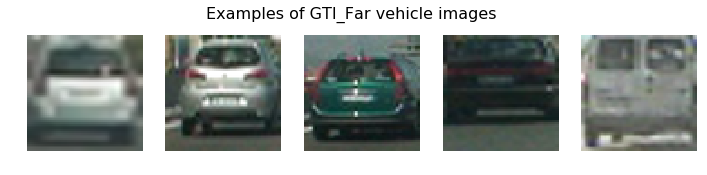

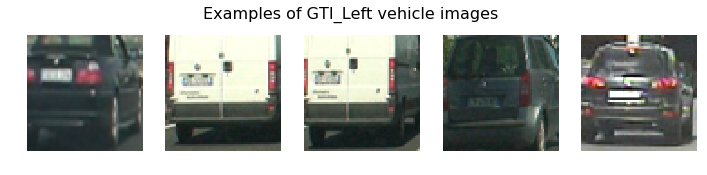

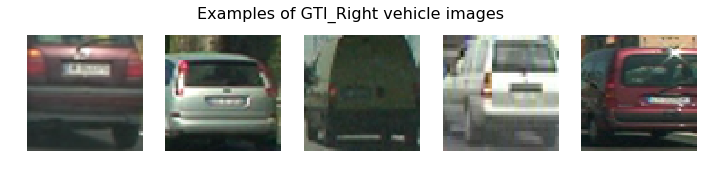

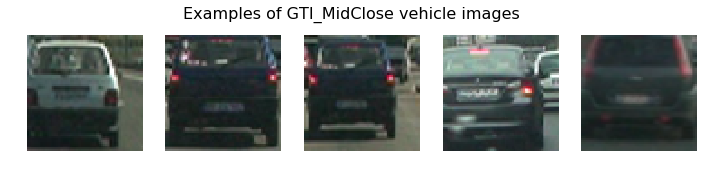

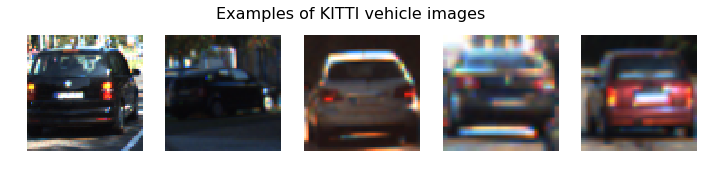

In [12]:
# plot some vehicle images
vahicle_lists = [
        vehicles_gti_far,
        vehicles_gti_left,
        vehicles_gti_right,
        vehicles_gti_mid,
        vehicles_kitti
    ]
title_list = [
        'Examples of GTI_Far vehicle images',
        'Examples of GTI_Left vehicle images',
        'Examples of GTI_Right vehicle images',
        'Examples of GTI_MidClose vehicle images',
        'Examples of KITTI vehicle images'
    ]
for i, sources in enumerate(vahicle_lists):
    plt.figure(figsize=(12,2.5))
    plt.suptitle(title_list[i], fontsize=16)
    for j, path in enumerate(sources[0:5]):
        img = mpimg.imread(path)
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    plt.close()

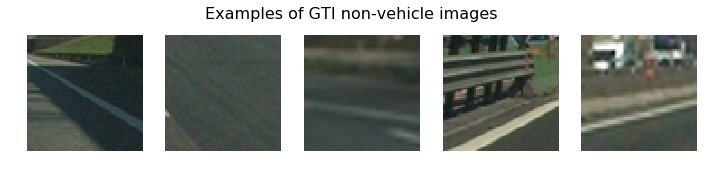

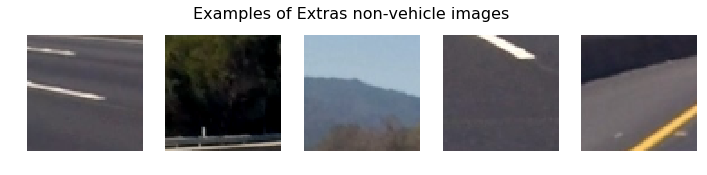

In [13]:
# plot some vehicle images
non_vahicle_lists = [
        non_vehicles_gti,
        non_vehicles_extras
    ]
title_list = [
        'Examples of GTI non-vehicle images',
        'Examples of Extras non-vehicle images'
    ]
for i, sources in enumerate(non_vahicle_lists):
    plt.figure(figsize=(12,2.5))
    plt.suptitle(title_list[i], fontsize=16)
    for j, path in enumerate(sources[0:5]):
        img = mpimg.imread(path)
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    plt.close()

### Dataset plots

In [14]:
# Numbers
print('Number of vehicles in GTI_Far: ' + str(len(vehicles_gti_far)))
print('Number of vehicles in GTI_Left: ' + str(len(vehicles_gti_left)))
print('Number of vehicles in GTI_Right: ' + str(len(vehicles_gti_right)))
print('Number of vehicles in GTI_MiddleClose: ' + str(len(vehicles_gti_mid)))
print('Number of vehicles in KITTI_extracted: ' + str(len(vehicles_kitti)))
print('Total number of vehicle examples: ' +
    str(
        len(vehicles_gti_far)
        + len(vehicles_gti_left)
        + len(vehicles_gti_right)
        + len(vehicles_gti_mid)
        + len(vehicles_kitti))
    )

print()
print('Number of non-vehicles in GTI: ' + str(len(non_vehicles_gti)))
print('Number of non-vehicles in Extras: ' + str(len(non_vehicles_extras)))
print('Total number of non-vehicle examples: '
    + str(len(non_vehicles_gti) + len(non_vehicles_extras)))

Number of vehicles in GTI_Far: 834
Number of vehicles in GTI_Left: 909
Number of vehicles in GTI_Right: 664
Number of vehicles in GTI_MiddleClose: 419
Number of vehicles in KITTI_extracted: 5966
Total number of vehicle examples: 8792

Number of non-vehicles in GTI: 3900
Number of non-vehicles in Extras: 5068
Total number of non-vehicle examples: 8968


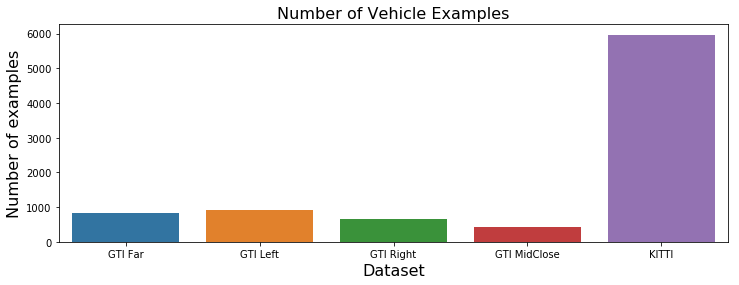

In [15]:
# plot number of vehicle examples
n_vehicles_gti_far = len(vehicles_gti_far)
n_vehicles_gti_left = len(vehicles_gti_left)
n_vehicles_gti_right = len(vehicles_gti_right)
n_vehicles_gti_mid = len(vehicles_gti_mid)
n_vehicles_kitti = len(vehicles_kitti)

vehicle_dataset_numbers = [
        n_vehicles_gti_far,
        n_vehicles_gti_left,
        n_vehicles_gti_right,
        n_vehicles_gti_mid,
        n_vehicles_kitti
    ]

vehile_dataset_labels = [
        'GTI Far',
        'GTI Left',
        'GTI Right',
        'GTI MidClose',
        'KITTI'
    ]

n_non_vehicles_gti = len(non_vehicles_gti)
n_non_vehicles_extras = len(non_vehicles_extras)

# plot num vehicles
plt.figure(figsize=(12,4))
plt.title('Number of Vehicle Examples', fontsize=16)
plt.ylabel('Number of examples', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
sns.barplot(x=vehile_dataset_labels, y=vehicle_dataset_numbers)
plt.show()
plt.close()

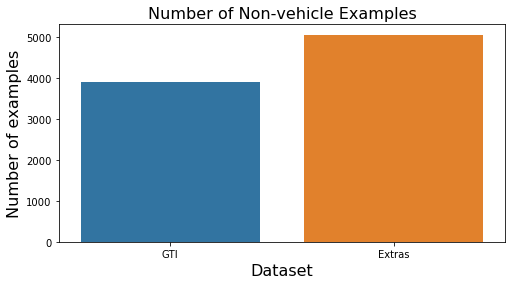

In [16]:
# plot number of vehicle examples
n_non_vehicles_gti = len(non_vehicles_gti)
n_non_vehicles_extras = len(non_vehicles_extras)

non_vehicle_dataset_numbers = [
        n_non_vehicles_gti,
        n_non_vehicles_extras
    ]
non_vehile_dataset_labels = [
        'GTI',
        'Extras'
    ]

# plot num non vehicles
plt.figure(figsize=(8,4))
plt.title('Number of Non-vehicle Examples', fontsize=16)
plt.ylabel('Number of examples', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
sns.barplot(x=non_vehile_dataset_labels, y=non_vehicle_dataset_numbers)
plt.show()
plt.close()

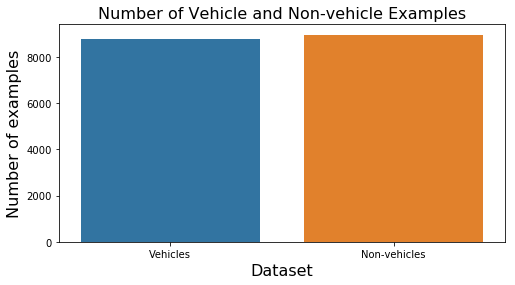

In [17]:
# plot vehicles and non-vehicles
n_vehicles = (
        n_vehicles_gti_far
        +n_vehicles_gti_left
        +n_vehicles_gti_right
        +n_vehicles_gti_mid
        +n_vehicles_kitti
    )
n_non_vehicles = n_non_vehicles_gti + n_non_vehicles_extras

n_list = [n_vehicles, n_non_vehicles]
n_labels = ['Vehicles', 'Non-vehicles']

plt.figure(figsize=(8,4))
plt.title('Number of Vehicle and Non-vehicle Examples', fontsize=16)
plt.ylabel('Number of examples', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
sns.barplot(x=n_labels, y=n_list)
plt.show()
plt.close()

---

For the classifier and training process please go on to [this notebook](./train-svm.ipynb).

---